In [1]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''
                                select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_train_zyjhk where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    if len(lcs)==0:

        lcs = pd.DataFrame(sqlutilpy.get('''
                                    select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(emag) as emag,
                                    unnest(filterid) as filterid,
                                    unnest(chi) as chi,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match  
                                    from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                         **config.wsdb_kwargs))
    
    return lcs


 ·············


In [2]:
def load_lc(sid, ra, dec):
    lc=get_lightcurve(sid)
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<11.829)&\
        (~((lc['chi']>5.)&(lc['mag']<13.2)))
    lc = sigclipper(lc[clean])

    correct_to_HJD(lc,
                 ra,
                 dec)
    return lc

def plot_lc_sid(sid,ra,dec,per,nterms,ax=None,reg=True,xlabel=False,right=False,offs=0,pcolor='gray',
               mcolor='#FFA500',ps='o',ttitle='',ylabel=True):
    
    lc = load_lc(sid, ra, dec)

    tt = lc['HJD'].values[np.argmin(np.abs(lc['mag'].values-np.nanpercentile(lc['mag'],98.)))]

    model = LombScargle(lc['HJD'].values-tt, lc['mag'].values, 
                        lc['emag'].values, normalization='standard')
    freq, power = model.autopower(maximum_frequency=10.)

    if xlabel:
        plt.xlabel('Phase')
    if ylabel:
        plt.ylabel(r'$K_s$ + arbitrary offset [mag] ')
#     nterms=combo_dset['lsq_nterms'].values[fltr][ii]
    opt_reg=0
    if reg:
        opt_reg=optimum_regularization(lc['mag'].values, lc['emag'].values)

    results_d = fourier_poly_chi2_fit_full(
                                             times=lc['HJD'].values-tt,
                                             mag=lc['mag'].values,
                                             err=lc['emag'].values,
                                             freq_dict={'freq_grid':np.array([1./per])},
                                             nterms=np.int64(nterms),
                                             npoly=2,
                                             regularization=opt_reg,
                                             time_zeropoint_poly=0.,
                                             regularize_by_trace = True,
                                             check_multiples=False, 
                                             use_power_of_2=False,
                                             return_period_error=False)

    xx=np.linspace(-1.1*per,3.1*per,5000)
    FF = retrieve_fourier_poly(xx,
                               results_d)
    xx0 = xx[np.argmax(FF[xx<0])]
    
    plt.errorbar((((lc['HJD'].values-tt-xx0)%(2.*per))/per),
                 lc['mag'].values-np.nanmedian(FF)+offs,
                 yerr=lc['emag'].values,fmt=ps,color=pcolor,mew=0.5,mec='k',alpha=0.5,ms=5,
                rasterized=True)
#     plt.ylim(np.nanmean(lc['mag'].values)-0.3,np.nanmean(lc['mag'].values)+0.3)
    plt.gca().invert_yaxis()
    plt.xlim(-0.1,2.1)
    # plt.ylim(-0.5,0.5)
    
    tt = plt.annotate('%0.2fd'%per,xy=(2.,offs),ha='right',va='center',zorder=100,fontsize=12)
    tt.set_bbox({'facecolor':'white', 'alpha':0.7,'edgecolor':'None','pad':1.})
    
    plt.plot((xx-xx0)/per, FF-np.nanmedian(FF)+offs,color=mcolor,lw=3,zorder=10,alpha=0.85)

    if offs==0:
        plt.ylim(np.nanmax(FF)+0.15-np.nanmedian(FF),np.nanmin(FF)-0.15-np.nanmedian(FF))
    
    if right:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    plt.title(ttitle,fontsize=16)
    return results_d

In [3]:
from matplotlib.ticker import LogLocator, ScalarFormatter
from fine_classif.feat_extract.compute_feats import sigclipper, correct_to_HJD, LombScargle, optimum_regularization, fourier_poly_chi2_fit_full, retrieve_fourier_poly

In [4]:
import sqlutilpy
full_data=pd.DataFrame(sqlutilpy.get("select p.*,v.ks_ivw_mean_mag,v.ra,v.dec,v.pmra,v.pmdec,v.pmra_error,v.pmdec_error,v.pmra_pmdec_corr,v.l,v.b from thomas_molnar.virac2_variable_sources_eaeb as p inner join thomas_molnar.virac2_variable_data as v on p.sourceid=v.sourceid", 
                                     **config.wsdb_kwargs))

In [5]:
def period_fix(var_in,tol=1.):

    period_out = var_in['lsq_period'].values.copy()

    period_out[((var_in['class']=='EA/EB')|(var_in['class']=='Ell'))&
                (var_in['amp_0']>tol*var_in['amp_1'])]*=2.
    
    ss=np.argmax([var_in['amp_0'].values,
                  var_in['amp_1'].values,
                  var_in['amp_2'].values,
                  var_in['amp_3'].values],axis=0)
    fltr = ~((var_in['class']=='EA/EB')|(var_in['class']=='Ell'))
    period_out[fltr]/=(1.+ss)[fltr]
    
    period_out[var_in['class']=='EW']*=2
    
    return period_out
    

In [144]:
import seaborn as sns
from matplotlib.colors import to_hex
to_hex(sns.color_palette('Set3')[0])

'#8dd3c7'

In [50]:
fltr = (full_data['prob']>0.9)&(full_data['class']=='LPV')\
              &(np.abs(full_data['b'])<2.)&((full_data['l']>350.)|(full_data['l']<10.))\
            &(full_data['delta_loglik']>800.)&(full_data['lsq_period']<600.)

In [7]:
import sys
sys.path.append('../../../')
from gaussian_process import run_gp_quick, plot_lc_GP
sys.path.append('../../../../mira_project/')
sys.path.append('../../../../')
from find_analyse_variables import generate_results_gp

/data/jls/python3.5/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release ofcryptography. Please upgrade your Python.
  from cryptography.utils import int_from_bytes


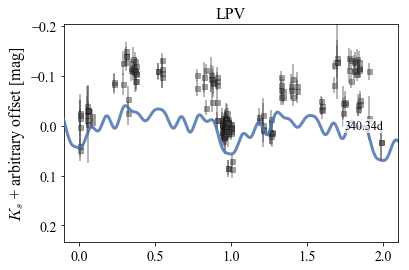

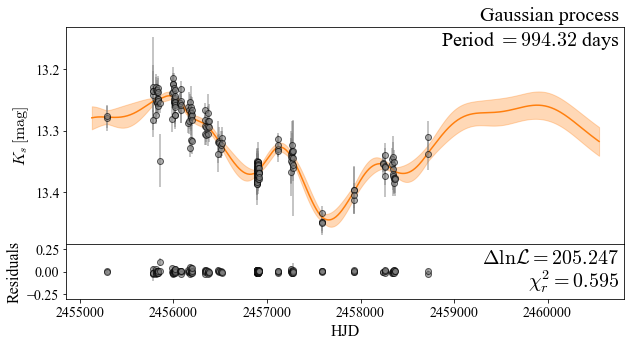

In [61]:
ii=25
jj=0
scl_factor=0.4
clss='LPV'
axii=0
plot_lc_sid(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii],
                    period_fix(full_data)[fltr][ii],
                    full_data[fltr]['lsq_nterms'].values[ii],
                    offs=jj*scl_factor,
                   mcolor='#FFA500'*(jj%2)+'#4c72b0'*((jj+1)%2),
                   pcolor='gray'*(jj%2)+'#404040'*((jj+1)%2),
                   ps='o'*(jj%2)+'s'*((jj+1)%2),ttitle=clss,ylabel=(axii==0));
LC = load_lc(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii])
LC['error']=LC['emag']
gpp=run_gp_quick(LC,per_guess=560.)
# gpp,gpprops, lcprops, dll, dllG, rchi, delta_aic, delta_bic=\
#             generate_results_gp(LC,[period_fix(full_data)[fltr][ii]])
plot_lc_GP(LC,gpp);

8080
0.630810477901928
0.561346030973545
0.639284128136063
0.454981002288769
0.561479931995838
0.58558912318273
0.525367073621056
0.49207945971015
30
0.285352242660615
0.429886706512871
0.319032296986534
0.306414184342075
0.321849316086245
0.320511084818753
0.271218937671848
0.277788268997143
20434
1.23765056197213
2.95662243549962
1.07673809242488
2.41156886160818
1.421125033220764
5.76043797721036
0.740856458975182
1.12821451766343
2516
0.527425524409332
0.398420077027506
0.383521938581334
0.466573184208504
0.472197939764602
0.434885491249704
0.472898902517658
0.559488958369004
2199
58.7996561796218
30.32459299073
10.92506061605986
62.6090520489376
13.97826143311442
45.2587632520234
70.740127895687
27.3271423259158
220
5.99800200073871
7.80590032011262
4.30557485189833
4.10094074484388
4.30349026114121
7.52771359874247
4.29959140841539
4.92193461617576
942
9.49201754695718
1.63843168921717
232.79378476186
2.14600902748427
1.95707204449896
2.02279747816761
1.34485522084862
16.24587720

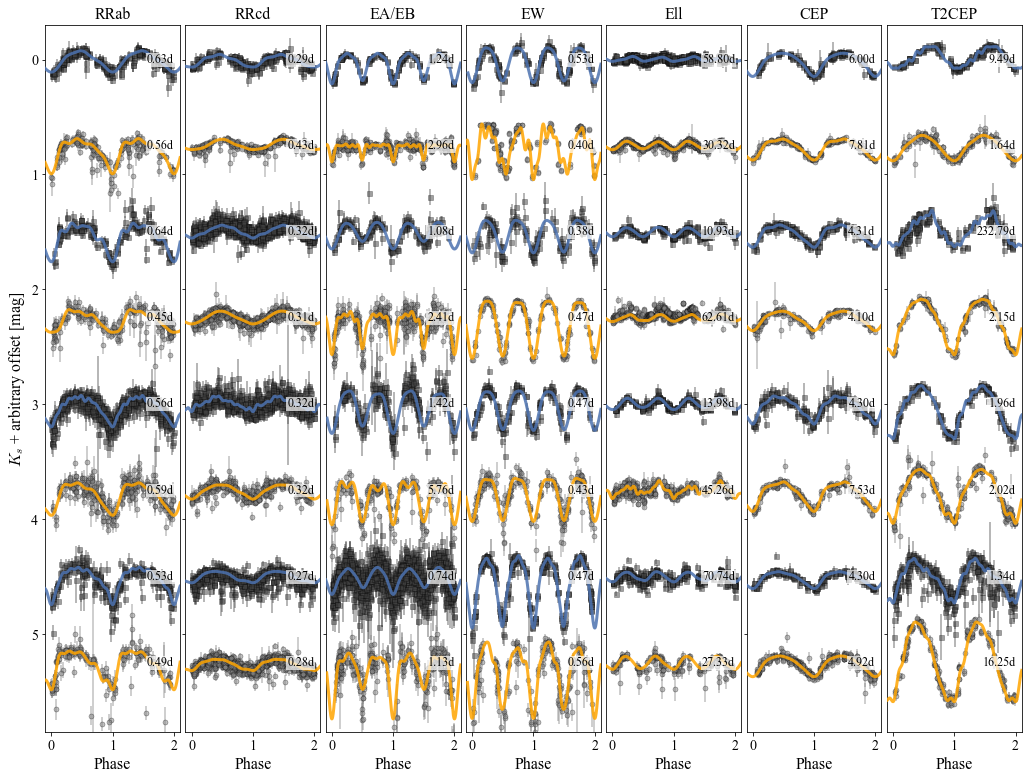

In [65]:
clss='RRab'

Ncol=7
fig,ax=plt.subplots(1,Ncol,figsize=[2.5*Ncol,13.],sharey=True)
plt.subplots_adjust(wspace=0.04,hspace=0.)

for axii, clss in enumerate(['RRab','RRcd','EA/EB','EW','Ell','CEP','T2CEP']):
    plt.sca(ax[axii])
    fltr = (full_data['prob']>0.9)&(full_data['class']==clss)\
              &(np.abs(full_data['b'])<2.)&((full_data['l']>350.)|(full_data['l']<10.))\
            &(full_data['delta_loglik']>300.)

    print(np.count_nonzero(fltr))
    np.random.seed(42)
    selection = np.random.choice(np.arange(np.count_nonzero(fltr)),np.min([np.count_nonzero(fltr),8]),replace=False)
    selection = selection[np.argsort(full_data['amplitude'].values[fltr][selection])]

    # plt.sca(a[0])
    scl_factor=0.75
    for jj, ii in enumerate(selection):
        print(period_fix(full_data)[fltr][ii])
    #     plt.sca(a[jj])
        plot_lc_sid(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii],
                    period_fix(full_data)[fltr][ii],
                    full_data[fltr]['lsq_nterms'].values[ii],
                    offs=jj*scl_factor,
                   mcolor='#FFA500'*(jj%2)+'#4c72b0'*((jj+1)%2),
                   pcolor='gray'*(jj%2)+'#404040'*((jj+1)%2),
                   ps='o'*(jj%2)+'s'*((jj+1)%2),ttitle=clss,ylabel=(axii==0));
    plt.ylim(-scl_factor*0.4,(len(selection)-1)*scl_factor+scl_factor*0.8)
    # plt.sca(a[-2]);plt.xlabel('Phase')
    # plt.sca(a[-1]);plt.xlabel('Phase')
    plt.xlabel('Phase')
    plt.gca().invert_yaxis()
plt.savefig('lc_gallery.pdf',bbox_inches='tight')

In [63]:
!ls -lt lc_gallery.pdf

-rw-r--r-- 1 jls jls 748297 May 19 12:02 lc_gallery.pdf
